<font size="5">

# General considerations for effective thermal neutron shielding in detector applications

<font size="3">

> __Author:__ A. Backis
<br/>__Institute:__ University of Glasgow (UoG), European Spallation Source (ESS)
<br/>__Date:__ 22/6-2021

_Abstract:_
This notebook contains the data analysis used in the paper 'General considerations for effective thermal neutron shielding in detector applications'. Additionally, a small tool is defined at the end of the notebook which can be used to find a suitable shielding material by following the steps laid out in the paper.

# Contents
* [1. Introduction](#INTRODUCTION)
    * [1.1 Overview](#OVERVIEW)
    * [1.2 Packages](#PACKAGES)
    * [1.3 Helper functions](#HELPER)
* [2. Data](#DATA)
* [3. Analysis](#ANALYSIS)
    * [3.1 Cross sections](#CROSS)
    * [3.2 Probabilities](#PROB)
        * [3.2.1 Transmission & Albedo](#TRANS)
        * [3.2.2 Side, Interstack and End](#SIDE_INTER_AND_END)
    * [3.3 Albedo saturation](#SAT)
    * [3.4 Transmission iso-lines](#ISO_LINES)
* [4. Shielding finder tool](#TOOL)
* [5. Custom material investigation](#CUSTOM)
* [6. Extra](#EXTRA)
* [Acknowledgements](#ACKNOWLEDGEMENTS)
* [References](#REFERENCES)

# 1. Introduction<a class="anchor" id="INTRODUCTION"></a>

The purpose of this notebook is to provide an easy-to-use tool to compare different shielding materials in terms of performance. This includes details on neutron transmission and albedo probabilities as a function of material thickness and incident neutron energy. It is also investigated how these propabilities change with material properties such as B-10 enrichement in B4C.

To investigate these properties, neutron absorption and scattering cross sections are extracted for each material using the ESS DG framework. In the notebook, cross section files for several materials are stored in the 'data'-folder. However, it is possible for the user to extract cross sections for more materials using the ESS DG framework. If the user already has the framework installed, then the new cross-sections can be simply extracted using the following syntax:

```
ess_g4xsectdump_query -m "MATERIAL"  -l "QGSP_BIC_HP_EMZ" -p "neutron"
```

Where MATERIAL is to be replaced with the desired material, for example G4_B or G4_Al. Once the cross sections are extracted, the files can be put in the 'data'-folder to make the files accessible to the notebook.

After the absorption and scattering cross sections have been extracted, the interaction probabilities are aproximated using the mean free path approximation according to

$$
\begin{equation}
P_{int} = 1 - \exp(-\bar{\sigma}_{mat}(E) \cdot \bar{\rho}_{mat} \cdot  t_{mat}),
\end{equation}
$$

where $\bar{\sigma}_{mat}$ is the average atomic interaction cross section of the material, $E$ is the incident neutron energy, $\bar{\rho}_{mat}$ is the average atomic density of the material and $t_{mat}$ is the material thickness. Note that $\bar{\sigma}_{mat}(E)$ and $\bar{\rho}_{mat}$ are extracted from the ESS DG software.

Once these interaction probabilities have been found, the transmission and albedo probabilities can be found according to


$$
\begin{equation}
P_{transmission} = (1-P_{absorption}) \cdot (1-\frac{1}{2}P_{scattering}),
\end{equation}
$$

and

$$
\begin{equation}
P_{albedo} =  \sum_{n=1}^{k} (1-P_{absorption}(n))^2 \cdot \frac{1}{2}(P_{scattering}(n)-P_{scattering}(n-1)).
\end{equation}
$$

In the above equations, $P_{absorption}$ and $P_{scattering}$ is the absorption and scattering probabilities, respectively, and the factor $1/2$ signifies that half the scattered neutrons are back-scattered. For the $P_{transmission}$, the shielding is treated as a solid block with thickness $t_{mat}$, while for $P_{albedo}$, the thickness $t_{mat}$ of the shielding material is split into ($k-1$) segments, and the summation variable $n$ denotes the depth boundaries of these segments. For each segment, the probability of a neutron reaching that segment without being absorbed, being back scattered in that segment, and then going all the way back out of the material, is calculated. The albedo probability is then calculated as the sum of that probability for each of the segments.

Once the albedo and transmission probabilities have been calculated, the probability of background neutrons escaping is calculated. This can be either transmission or albedo, depending on where the shielding is located inside the detector. For the different shielding locations, as shown in the paper, this is calculated according to:

$$
P_{side} = P_{transmission}
$$


$$
P_{end} =  P_{albedo} + P_{transmission}^2 \cdot P_{backscattering}
$$


$$
P_{interstack} = P_{transmission} + P_{albedo}
$$

Where $P_{side}$ is for side shielding, $P_{end}$ is for shielding at the back of the detector, and $P_{interstack}$ is for shielding inbetween adjacent shielding modules.


## 1.1 Overview<a class="anchor" id="OVERVIEW"></a>

First, the data parser is defined and the data used in the paper is imported and stored in a dictionary. After that, all the analytic calculations done for the paper is performed. This includes cross sections and transmission and albedo probabilities, amongst others. Then, the shielding finder tool is defined. The way this works, is that the user enters the performance demands and constraints for a specific detector shielding, and the tool will then indicate which shielding materials are suitable to reach those performance demands with the available space. Finally, there are options for the user to add new code and look at custom materials. To create custom materials, the ESS DG framework can be used to extract material cross-sections.

## 1.2 Packages<a class="anchor" id="PACKAGES"></a>

In [1]:
# Enable autoload of packages when doing an external change
%load_ext autoreload
%autoreload 2

# General packages
import os
import sys

# Install required analysis packages
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib

# Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm

# Activate matplotlib in interactive notebook mode
%matplotlib notebook

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.16/libexec/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.16/libexec/bin/python3.9 -m pip install --upgrade pip' command.


## 1.3 Helper functions<a class="anchor" id="HELPER"></a>

In [2]:
def set_thick_labels(thickness):
    """ Sets the matplotlib font sizes for the parts stated below
        to the thickness 'thickness'.

    Args:
        thickness (float): Font size

    Yields:
        Updated matplotlib font sizes

    """
    # Customize matplotlib font sizes
    plt.rc('font', size=thickness)          # Controls default text sizes
    plt.rc('axes', titlesize=thickness)     # Fontsize of the axes title
    plt.rc('axes', labelsize=thickness)     # Fontsize of the x and y labels
    plt.rc('xtick', labelsize=thickness)    # Fontsize of the tick labels
    plt.rc('ytick', labelsize=thickness)    # Fontsize of the tick labels
    plt.rc('legend', fontsize=thickness)    # Legend fontsize
    plt.rc('figure', titlesize=thickness)   # Fontsize of the figure title

def meV_to_A(energy_in_meV):
    """ Convert neutron energy in millielectronvolts to wavelength in Angstroms.
    
    Args:
        energy_in_meV (float): Neutron energy in meV

    Returns:
        wavelength_in_Angstrom (float): Neutron energy in Angstrom
    
    """
    wavelength_in_Angstrom = np.sqrt(81.81/energy_in_meV)
    return wavelength_in_Angstrom

def A_to_meV(wavelength_in_Angstrom):
    """ Convert neutron wavelength in Angstroms to energy in millielectronvolts.
    
    Args:
        wavelength_in_Angstrom (float): Neutron energy in Angstrom
        
    Returns:
        energy_in_meV (float): Neutron energy in meV
    
    """
    energy_in_meV = (81.81 /(wavelength_in_Angstrom ** 2))
    return energy_in_meV

# 2. Data<a class="anchor" id="DATA"></a>

First, we define a data parser to import the cross sections from the cross section files.

In [3]:
def parse_data(path):
    """ Function to parse neutron cross sections files generated by the ESS DG framework.

    Args:
        path (str): Path to the data to parse

    Returns:
        data (dict): Dictionary containing two arrays: one with absorption cross sections
                     and one with scattering cross sections (each with corresponding energies in eV).
                     The cross sections are stated in barns.
        density (float): The atomic density of the material

    """
    # Get data separators indexes, adjusted for deleted comments lines
    idxs = {'hadElastic': None, 'neutronInelastic': None, 'nCapture': None, 'Total': None}
    with open(path) as f:
        lines = np.array([[line.rstrip(), line.rstrip()[1:8], line.rstrip()[12:]] for line in f]).transpose()
        delimiter_idxs = np.where(lines[1] == 'Process')[0]
        delimiter_processes = lines[2][delimiter_idxs]
        data_start = delimiter_idxs[0]
        data_end = len(lines[0]) - (data_start + 4)
        idx_0 = delimiter_idxs[0] - data_start
        idx_1 = delimiter_idxs[1] - (data_start+1)
        idx_2 = delimiter_idxs[2] - (data_start+2)
        idx_3 = delimiter_idxs[3] - (data_start+3)
        idxs[delimiter_processes[0]] = [idx_0, idx_1]
        idxs[delimiter_processes[1]] = [idx_1, idx_2]
        idxs[delimiter_processes[2]] = [idx_2, idx_3]
        idxs[delimiter_processes[3]] = [idx_3, data_end+1]
    # Get relevant meta-data value
    keys, values = np.loadtxt(path, comments=None, dtype='str', delimiter=': ', max_rows=data_start+1, unpack=True)
    density = float(values[np.where(keys == '#NAtomsPerVolume [1/cm3]')][0])
    # Get data
    energies, xsects = np.loadtxt(path, unpack=True)
    ## hadElastic
    energies_hadElastic = energies[idxs['hadElastic'][0]:idxs['hadElastic'][1]]
    xsects_hadElastic = xsects[idxs['hadElastic'][0]:idxs['hadElastic'][1]]
    ## neutronInelastic
    energies_neutronInelastic = energies[idxs['neutronInelastic'][0]:idxs['neutronInelastic'][1]]
    xsects_neutronInelastic = xsects[idxs['neutronInelastic'][0]:idxs['neutronInelastic'][1]]
    ## nCapture
    energies_nCapture = energies[idxs['nCapture'][0]:idxs['nCapture'][1]]
    xsects_nCapture = xsects[idxs['nCapture'][0]:idxs['nCapture'][1]]
    ## Total
    energies_Total = energies[idxs['Total'][0]:idxs['Total'][1]]
    xsects_Total = xsects[idxs['Total'][0]:idxs['Total'][1]]    
    ## Calculate offset between 'Total' and 'hadElastic'
    offset = np.where(energies_hadElastic == energies_Total[0])[0][0]    
    ## Recalculate to absorption and scattering
    energies_scattering, xsects_scattering = energies_hadElastic, xsects_hadElastic
    energies_absorption, xsects_absorption = energies_Total, (xsects_Total - xsects_hadElastic[offset:])
    ## Cross-check that array operations are correct
    if (sum(energies_Total - energies_hadElastic[offset:])) != 0:
        print('If sum is not zero, something is wrong.')
    # Store data in dictionary
    data = {'absorption': np.array([energies_absorption, xsects_absorption]),
            'scattering': np.array([energies_scattering, xsects_scattering])
            }
    return data, density

Then, we import the data and store it in a dictionary called 'data_array'. In the dictionary, each material is represented as a separate small dictionary, which contains the relevant information, such as absorption and scattering cross sections (stored in 'data') as well as density, label and file name.

Additionally, we define a dictionary called 'plot_groups', which contains information for how the plotting should be done. This includes which materials are to be paired (i.e. natural and enriched B4C), which linestyle and color the plots should have, as well as their respective labels.

In [4]:
# Declare dictionary to store data
data_array = {'Cd': {'file_name': 'Cd.txt',
                     'label': 'Cd',
                     'data': None,
                     'density': None},
              
              'Gd2O3': {'file_name': 'Gd2O3.txt',
                        'label': 'Gd$_2$O$_3$',
                        'data': None,
                        'density': None},
              
              'B4C_nat': {'file_name': 'B4C_nat.txt',
                          'label': 'B$_4$C ($^{10}$B/B: 20 at.%)',
                          'data': None,
                          'density': None},
              
              'B4C_enriched': {'file_name': 'B4C_enriched.txt',
                               'label': 'B$_4$C ($^{10}$B/B: 99 at.%)',
                               'data': None,
                               'density': None},
              
              'LiF_nat': {'file_name': 'LiF_nat.txt',
                          'label': 'LiF ($^{6}$Li/Li: 8 at.%)',
                          'data': None,
                          'density': None},
              
              'LiF_enriched': {'file_name': 'LiF_enriched.txt',
                               'label': 'LiF ($^{6}$Li/Li: 99 at.%)',
                               'data': None,
                               'density': None},
             
              'epoxy_Gd2O3_09_01': {'file_name': 'epoxy_Gd2O3_09_01.txt',
                                    'label': 'epoxy-Gd$_2$O$_3$ (w/w ratio: 0.9-0.1)',
                                    'data': None,
                                    'density': None},
              
              'epoxy_Gd2O3_01_09': {'file_name': 'epoxy_Gd2O3_01_09.txt',
                                    'label': 'epoxy-Gd$_2$O$_3$ (w/w ratio: 0.1-0.9)',
                                    'data': None,
                                    'density': None}
              }

# Define plot groups
plot_groups = {'Cd': {'materials': ['Cd'],
                      'color': 'green',
                      'label': 'Cd',
                      'linestyle': 'dotted'},
               
               'Gd2O3': {'materials': ['Gd2O3'],
                         'color': 'black',
                         'label': 'Gd$_2$O$_3$',
                         'linestyle': '-.'},
               
               'B4C': {'materials': ['B4C_nat', 'B4C_enriched'],
                       'color': 'red',
                       'label': 'B$_4$C ($^{10}$B/B: 20-99 at.%)',
                       'linestyle': '--'},
               
               'LiF': {'materials': ['LiF_nat', 'LiF_enriched'],
                       'color': 'blue',
                       'label': 'LiF ($^{6}$Li/Li: 8-99 at.%)',
                       'linestyle': '-'},
               
               'epoxy_Gd2O3': {'materials': ['epoxy_Gd2O3_09_01', 'epoxy_Gd2O3_01_09'],
                               'color': 'orange',
                               'label': 'epoxy-Gd$_2$O$_3$\n(w/w ratio: 0.9-0.1 to 0.1-0.9)',
                               'linestyle': '-.'}
              }

# Import data
for material in data_array.keys():
    # Get data and density
    file_name = data_array[material]['file_name']
    path = 'data/%s' % file_name
    data, density = parse_data(path)
    # Store in array
    data_array[material]['data'] = data
    data_array[material]['density'] = density

# 3. Analysis<a class="anchor" id="ANALYSIS"></a>

## 3.1 Cross sections<a class="anchor" id="CROSS"></a>

First, we define a function to plot the absorption and scattering cross sections (in barn) as a function of neutron energy (in eV) for all materials under investigation.

In [5]:
def plot_cross_sections(data_array, plot_groups, ymin=1e-2, ymax=1e10):
    """ Function to plot absorption and scattering cross sections for a series of materials.

    Args:
        data_array (dict): Dictionary containg all relevant material data
        plot_groups (dict): Dictionary conating all information for how the plotting should be done.
                            This includes which materials are to be paired (i.e. natural and enriched B4C),
                            which linestyle and color the plots should have, as well as labels.
        ymin (float): Minimum y-value of plot (in barns)
        ymax (float): Maximum y-value of plot (in barns)

    Yields:
        Plots depicting the absorption and scattering cross sections. The plot is also saved in the 
        'output'-folder.

    """
    # Prepare plot
    set_thick_labels(12)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
    plt.subplots_adjust(wspace=.01)

    # Plot cross sections from all materials
    for plot_group in plot_groups.values():
        # Extract values
        materials = plot_group['materials']
        color = plot_group['color']
        label = plot_group['label']
        linestyle = plot_group['linestyle']
        # Plot values
        if len(materials) == 1:
            # Extract values
            material = materials[0]
            data = data_array[material]['data']
            abs_cross, scatter_cross = data['absorption'], data['scattering']
            # Plot
            ax1.plot(abs_cross[0], abs_cross[1], color=color, label=label, linestyle=linestyle)
            ax2.plot(scatter_cross[0], scatter_cross[1], color=color, label=label, linestyle=linestyle)
        else:
            # Extract values
            material_1, material_2 = materials[0], materials[1]
            data_1, data_2 = data_array[material_1]['data'], data_array[material_2]['data']
            abs_cross_1, abs_cross_2 = data_1['absorption'], data_2['absorption']
            scatter_cross_1, scatter_cross_2 = data_1['scattering'], data_2['scattering']
            # Plot
            ax1.plot(abs_cross_1[0], abs_cross_1[1], color=color, label=None, linestyle=linestyle)
            ax1.plot(abs_cross_2[0], abs_cross_2[1], color=color, label=None, linestyle=linestyle)
            ax1.fill_between(abs_cross_1[0], abs_cross_2[1], abs_cross_1[1],
                             color=color, label=label, alpha=0.3)
            ax2.plot(scatter_cross_1[0], scatter_cross_1[1], color=color, label=None, linestyle=linestyle)
            ax2.plot(scatter_cross_2[0], scatter_cross_2[1], color=color, label=None, linestyle=linestyle)
            ax2.fill_between(scatter_cross_1[0], scatter_cross_2[1], scatter_cross_1[1],
                             color=color, label=label, alpha=0.3)

    # Stylize plot
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Energy (eV)')
    ax1.set_ylabel('$\overline{\sigma}$ (barn)')
    ax1.grid(True, which='major', linestyle='--', zorder=0)
    ax1.grid(True, which='minor', linestyle='--', zorder=0)
    ax1.set_ylim(ymin, ymax)
    ax1.legend(title='Material', loc=1)
    ax1.add_artist(AnchoredText("Absorption", loc=2))
    ax1.fill_betweenx([ymin, ymax], 0.0001, 1, color='grey', alpha=0.2, label=None, zorder=0)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Energy (eV)')
    ax2.grid(True, which='major', linestyle='--', zorder=0)
    ax2.grid(True, which='minor', linestyle='--', zorder=0)
    ax2.add_artist(AnchoredText("Scattering", loc=2))
    ax2.fill_betweenx([ymin, ymax], 0.0001, 1, color='grey', alpha=0.2, label=None, zorder=0)
    fig.set_figheight(5)
    fig.set_figwidth(12)
    plt.tight_layout()

    # Save plot
    fig.savefig('output/material_absorption_and_scattering_vs_ev.pdf', bbox_inches='tight')

Then we plot the cross sections for all materials under investigation.

<IPython.core.display.Javascript object>


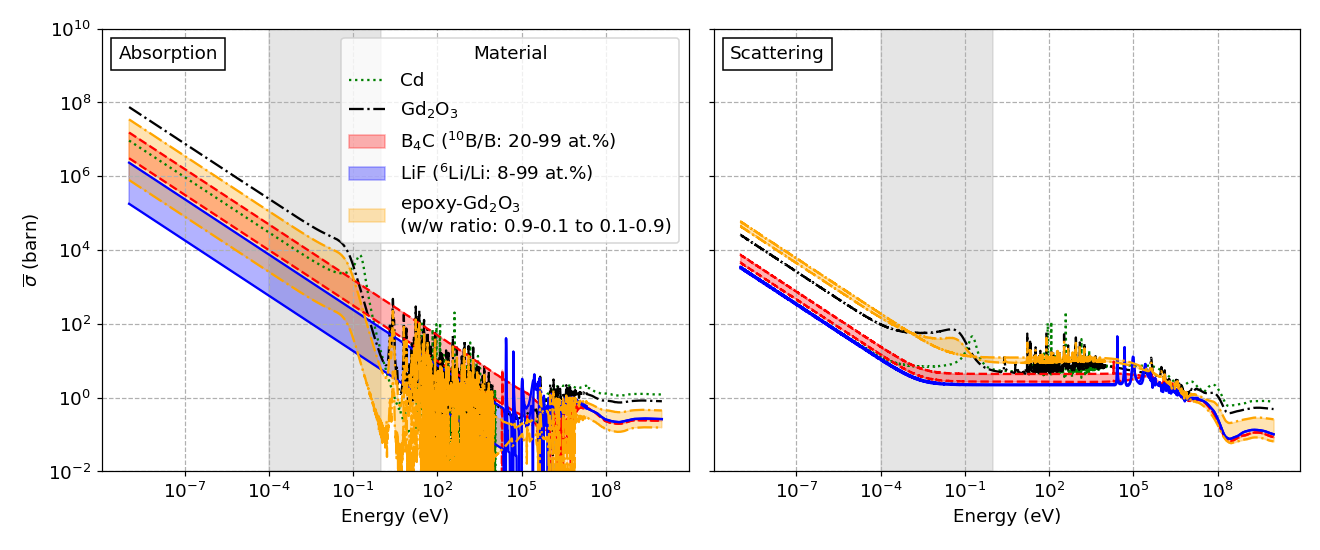

In [6]:
plot_cross_sections(data_array, plot_groups)

## 3.2. Probabilities<a class="anchor" id="PROB"></a>

## 3.2.1. Transmission & Albedo<a class="anchor" id="TRANS_AND_ALBEDO"></a>

First, we define a set of useful helper functions.

In [10]:
def get_idx_closest(array, value):
    """ Returns the index of the floating number which is the closest to 'value' in the array 'array'.

    Args:
        array (numpy.array): Array to be searched
        value (float): Number to be compared with the array elements

    Returns:
        idx_closest (int): Index of closest value in array
        
    """
    idx_closest = min(enumerate(array), key=lambda x: abs(x[1]-value))[0]
    return idx_closest

def get_sigma_of_energy(energy_and_cross, energy):
    """ Returns the cross section 'sigma' corresponding to the closest
        energy to 'energy' in the array 'energy_and_cross'.

    Args:
        energy_and_cross (numpy.array): Array to be searched for the closest cross section
        energy (float): Energy to which the corresponding cross section should be found

    Returns:
        sigma (float): Cross section corresponding to the closest energy to 'energy'
                       in the array 'energy_and_cross', in units barn.
    """
    sigma = energy_and_cross[1][get_idx_closest(energy_and_cross[0], energy)]
    return sigma

def get_probability(sigma, density, thickness):
    """ Returns the neutron interaction probability corresponding to the
        cross section 'sigma', density 'density' and material thickness 'thickness'.
        Note that all values are expressed in different units of length cm.

    Args:
        sigma (float): Cross section in unit cm^2
        density (float): Density in unit 1/cm^3 (#atoms per cubic cm)
        thickness (float): Thickness in unit cm

    Returns:
        interaction_probability (float): Neutron interaction probability corresponding
                                         to the cross section, density and material thickness entered.
                                         
    """
    interaction_probability = 1 - np.exp(-sigma*density*thickness)
    return interaction_probability

def get_transmission(p_absorption, p_scattering):
    """ Returns transmission as a function of thickness.

    Args:
        p_absorption (np.array): Absorption as a function of thickness (strictly increasing thicknesses)
        p_scattering (np.array): Scattering as a function of thickness (strictly increasing thicknesses)

    Returns:
        p_transmission (np.array): Transmission as a function of thickness (strictly increasing thicknesses)
        
    """
    p_transmission = (1 - p_absorption) * (1 - 0.5*p_scattering)
    return p_transmission

def get_albedo(p_absorption, p_scattering):
    """ Returns albedo as a function of thickness.

    Args:
        p_absorption (np.array): Absorption as a function of thickness (strictly increasing thicknesses)
        p_scattering (np.array): Scattering as a function of thickness (strictly increasing thicknesses)

    Returns:
        p_albedo (np.array): Albedo as a function of thickness (strictly increasing thicknesses)
        
    """
    p_albedo_elements = ((1 - p_absorption[1:]) ** 2) * 0.5 * np.diff(p_scattering)
    p_albedo = np.empty([len(p_albedo_elements)], dtype='float')
    for i in range(0, len(p_albedo_elements)):
        p_albedo[i] = sum(p_albedo_elements[:i+1])
    return p_albedo

def get_prob_vs_thickness(data, energy, density, thicknesses):
    """ Returns transmission and albedo as a function of thickness.

    Args:
        data (dict): Dictionary containing two arrays: one with absorption cross sections
                     and one with scattering cross sections (each with corresponding energies in eV).
                     The cross sections are stated in barns.
        energy (float): Energy in eV
        density (float): Density expressed as atoms per cm^3
        thicknesses (np.array): Thicknesses in cm

    Returns:
        p_transmission (np.array): Transmission as a function of thickness (strictly increasing thicknesses)
        p_albedo (np.array): Albedo as a function of thickness (strictly increasing thicknesses)
        
    """
    # Declare parameters
    barn_to_cm2 = 1e-24
    # Extract cross sections
    sigma_absorption = get_sigma_of_energy(data['absorption'], energy) * barn_to_cm2
    sigma_scattering = get_sigma_of_energy(data['scattering'], energy) * barn_to_cm2
    # Get scattering and absorption probabilities
    p_absorption = get_probability(sigma_absorption, density, thicknesses)
    p_scattering = get_probability(sigma_scattering, density, thicknesses)
    # Get transmission and albedo
    p_transmission = get_transmission(p_absorption, p_scattering)
    p_albedo = get_albedo(p_absorption, p_scattering)
    return p_transmission, p_albedo


Then, we define a function to plot transmission and albedo as a function of material thickness, for a fixed energy.

In [11]:
def plot_transmission_and_albedo(plot_groups, data_array, energy):
    """ Function to plot transmission and albedo as a function of thickness

    Args:
        plot_groups (dict): Dictionary conating all information for how the plotting should be done.
                            This includes which materials are to be paired (i.e. natural and enriched B4C),
                            which linestyle and color the plots should have, as well as labels.
        data_array (dict): Dictionary containg all relevant material data
        energy (float): Minimum y-value of plot (in barns)

    Yields:
        Plot depicting the transmission and albedo probabilities as a function of thickness.
        The plot is also saved in the 'output'-folder.

    """
    # Declare parameters
    xmin, xmax = 1e-3, 1e2
    ymin, ymax = 1e-6, 1
    thicknesses = np.logspace(-7, 2, 1000) * 0.1  # in cm
    
    # Prepare plot
    set_thick_labels(12)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
    plt.subplots_adjust(wspace=.01)

    # Plot cross sections from all materials
    for plot_group in plot_groups.values():
        # Extract values
        materials = plot_group['materials']
        color = plot_group['color']
        label = plot_group['label']
        linestyle = plot_group['linestyle']
        # Plot values
        if len(materials) == 1:
            # Extract avlues
            material = materials[0]
            data = data_array[material]['data']
            density = data_array[material]['density']
            # Calculate probabilities
            p_transmission, p_albedo = get_prob_vs_thickness(data, energy, density, thicknesses)
            # Plot
            ax1.plot(thicknesses*10, p_transmission, color=color, label=label, linestyle=linestyle)
            ax2.plot(thicknesses[1:]*10, p_albedo, color=color, label=label, linestyle=linestyle)
        else:
            # Extract values
            material_1, material_2 = materials[0], materials[1]
            data_1, data_2 = data_array[material_1]['data'], data_array[material_2]['data']
            density_1, density_2 = data_array[material_1]['density'], data_array[material_2]['density']
            # Calculate probabilites
            p_transmission_1, p_albedo_1 = get_prob_vs_thickness(data_1, energy, density_1, thicknesses)
            p_transmission_2, p_albedo_2 = get_prob_vs_thickness(data_2, energy, density_2, thicknesses)
            # Plot
            ax1.plot(thicknesses*10, p_transmission_1, color=color, label=None, linestyle=linestyle)
            ax1.plot(thicknesses*10, p_transmission_2, color=color, label=None, linestyle=linestyle)
            ax1.fill_between(thicknesses*10, p_transmission_2, p_transmission_1,
                             color=color, label=label, alpha=0.3)
            ax2.plot(thicknesses[1:]*10, p_albedo_1, color=color, label=None, linestyle=linestyle)
            ax2.plot(thicknesses[1:]*10, p_albedo_2, color=color, label=None, linestyle=linestyle)
            ax2.fill_between(thicknesses[1:]*10, p_albedo_2, p_albedo_1,
                             color=color, label=label, alpha=0.3)

    # Stylize plot
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Thickness (mm)')
    ax1.set_ylabel('Probability')
    ax1.grid(True, which='major', linestyle='--', zorder=0)
    ax1.grid(True, which='minor', linestyle='--', zorder=0)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    ax1.legend(title='Material', loc=3)
    ax1.add_artist(AnchoredText("Transmission", loc=1))
    
    ax2.set_xlim(xmin, xmax)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Thickness (mm)')
    ax2.grid(True, which='major', linestyle='--', zorder=0)
    ax2.grid(True, which='minor', linestyle='--', zorder=0)
    ax2.add_artist(AnchoredText("Albedo", loc=1))
    fig.set_figheight(5)
    fig.set_figwidth(12)
    plt.tight_layout()

    # Save plot
    fig.savefig('output/albedo_and_transmission_at_%.4f_eV.pdf' % energy, bbox_inches='tight')


Finally, we run the script for 25 meV neutrons.

<IPython.core.display.Javascript object>


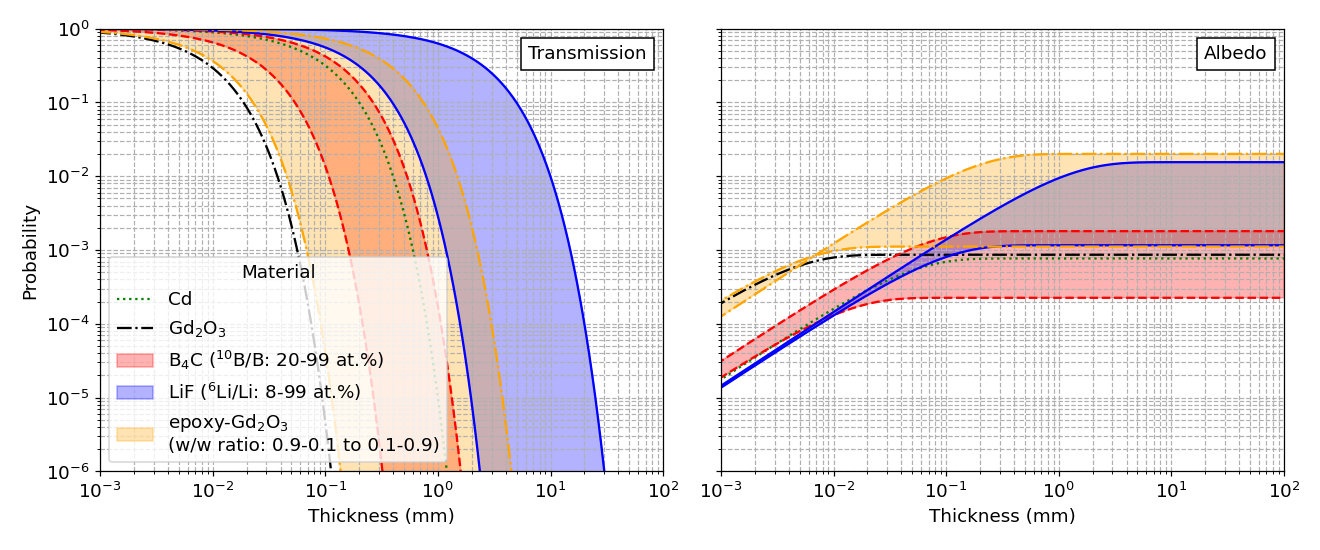

In [12]:
energy_in_eV = 0.02525
plot_transmission_and_albedo(plot_groups, data_array, energy_in_eV)

## 3.2.2. Side, Interstack and End<a class="anchor" id="SIDE_INTER_AND_END"></a>

First, we define a helper function to calculate the probabilites.

In [13]:
def get_prob_side_interstack_and_end(p_transmission, p_albedo, p_back_scattering=0.5):
    """ Function to get the probability of getting a background neutron from the side, interstack 
        and end shielding as a function of thickness.

    Args:
        p_transmission (np.array): Transmission as a function of thickness (strictly increasing thicknesses)
        p_albedo (np.array): Albedo as a function of thickness (strictly increasing thicknesses)
        p_back_scattering (float): Probability of a neutron being back scattered of the material behind
                                   the neutron detector.

    Returns:
        p_side (np.array): Probability of getting a background neutron from the side shielding
                           as a function of thickness
        p_interstack (np.array): Probability of getting a background neutron from the interstack shielding
                                 as a function of thickness
        p_end (np.array): Probability of getting a background neutron from the end shielding
                          as a function of thickness

    """
    p_side = p_transmission[1:]
    p_interstack = p_transmission[1:] + p_albedo
    p_end = p_albedo + (p_transmission[1:] ** 2) * p_back_scattering
    return p_side, p_interstack, p_end

Then, we define a function to plot the different probabilities.

In [14]:
def plot_probabilities(plot_groups, data_array, energy, constraints=None):
    """ Function to plot probability of getting background neutrons from the different shielding components
        as a function of thickness.

    Args:
        plot_groups (dict): Dictionary conating all information for how the plotting should be done.
                            This includes which materials are to be paired (i.e. natural and enriched B4C),
                            which linestyle and color the plots should have, as well as labels.
        data_array (dict): Dictionary containg all relevant material data
        energy (float): Minimum y-value of plot (in barns)
        constraints (dict): Dictionary containing the constraints on how thick the different shielding can
                            be and what the desired background probabilities should be kept below.
                            The constraints dict is expressed in the following format:

                                constraints = {'constraints_side': [space_available_side,
                                                                    p_side_maximum],
                                               'constraints_end': [space_available_end,
                                                                   p_end_maximum],
                                               'constraints_interstack': [space_available_interstack,
                                                                          p_interstack_maximum]
                                               }

    Yields:
        Plot depicting the probability of getting background neutrons from the different shielding components
        as a function of thickness. The plot is also saved in the 'output'-folder.

    """
    # Declare parameters
    xmin, xmax = 1e-3, 1e2
    ymin, ymax = 1e-6, 1
    thicknesses = np.logspace(-7, 2, 1000) * 0.1  # in cm
    
    # Prepare plot    
    set_thick_labels(9)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, sharey=True)
    plt.subplots_adjust(hspace=.08)
    if constraints is not None:
        fig.suptitle('Energy: %.3f eV (%.3f Å)' % (energy, meV_to_A(energy*1000)))

    # Plot cross sections from all materials
    for plot_group in plot_groups.values():
        # Extract values
        materials = plot_group['materials']
        color = plot_group['color']
        label = plot_group['label']
        linestyle = plot_group['linestyle']
        # Plot values
        if len(materials) == 1:
            # Extract values
            material = materials[0]
            data = data_array[material]['data']
            density = data_array[material]['density']
            # Calculate probabilities
            p_transmission, p_albedo = get_prob_vs_thickness(data, energy, density, thicknesses)
            p_side, p_interstack, p_end = get_prob_side_interstack_and_end(p_transmission, p_albedo)
            # Plot
            ax1.plot(thicknesses[1:]*10, p_side, color=color, label=label, linestyle=linestyle)
            ax2.plot(thicknesses[1:]*10, p_interstack, color=color, label=label, linestyle=linestyle)
            ax3.plot(thicknesses[1:]*10, p_end, color=color, label=label, linestyle=linestyle)
        else:
            # Extract values
            material_1, material_2 = materials[0], materials[1]
            data_1, data_2 = data_array[material_1]['data'], data_array[material_2]['data']
            density_1, density_2 = data_array[material_1]['density'], data_array[material_2]['density']
            # Calculate probabilities
            p_transmission_1, p_albedo_1 = get_prob_vs_thickness(data_1, energy, density_1, thicknesses)
            p_transmission_2, p_albedo_2 = get_prob_vs_thickness(data_2, energy, density_2, thicknesses)
            p_side_1, p_interstack_1, p_end_1 = get_prob_side_interstack_and_end(p_transmission_1, p_albedo_1)
            p_side_2, p_interstack_2, p_end_2 = get_prob_side_interstack_and_end(p_transmission_2, p_albedo_2)
            # Plot
            ax1.plot(thicknesses[1:]*10, p_side_1, color=color, label=None, linestyle=linestyle)
            ax1.plot(thicknesses[1:]*10, p_side_2, color=color, label=None, linestyle=linestyle)
            ax1.fill_between(thicknesses[1:]*10, p_side_2, p_side_1,
                             color=color, label=label, alpha=0.3)
            ax2.plot(thicknesses[1:]*10, p_interstack_1, color=color, label=None, linestyle=linestyle)
            ax2.plot(thicknesses[1:]*10, p_interstack_2, color=color, label=None, linestyle=linestyle)
            ax2.fill_between(thicknesses[1:]*10, p_interstack_2, p_interstack_1,
                             color=color, label=label, alpha=0.3)
            ax3.plot(thicknesses[1:]*10, p_end_1, color=color, label=None, linestyle=linestyle)
            ax3.plot(thicknesses[1:]*10, p_end_2, color=color, label=None, linestyle=linestyle)
            ax3.fill_between(thicknesses[1:]*10, p_end_2, p_end_1,
                             color=color, label=label, alpha=0.3)
        
    # Stylize plot
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(True, which='major', linestyle='--', zorder=0)
    ax1.grid(True, which='minor', linestyle='--', zorder=0)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    ax1.legend(title='Material', loc=3)
    ax1.set_ylabel('$P_{transmission}$')
    ax1.add_artist(AnchoredText('$P_{side}$', loc=1))
    if constraints is not None:
        space_available_side, p_side_maximum = constraints['constraints_side']
        ax1.fill_betweenx([ymin, p_side_maximum], xmin, space_available_side, color='lime',
                          alpha=0.3, label=None, zorder=0)
    
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin, ymax)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, which='major', linestyle='--', zorder=0)
    ax2.grid(True, which='minor', linestyle='--', zorder=0)
    ax2.set_ylabel('$P_{transmission} + P_{albedo}$')
    ax2.add_artist(AnchoredText('$P_{interstack}$', loc=1))
    if constraints is not None:
        space_available_interstack, p_interstack_maximum = constraints['constraints_interstack']
        ax2.fill_betweenx([ymin, p_interstack_maximum], xmin, space_available_interstack, color='lime',
                          alpha=0.3, label=None, zorder=0)
    
    ax3.set_xlim(xmin, xmax)
    ax3.set_ylim(ymin, ymax)
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.grid(True, which='major', linestyle='--', zorder=0)
    ax3.grid(True, which='minor', linestyle='--', zorder=0)
    ax3.set_xlabel('Thickness (mm)')
    ax3.set_ylabel('$P_{albedo} + P_{transmission}^2P_{backscattering}$')
    ax3.add_artist(AnchoredText('$P_{end}$', loc=1))
    if constraints is not None:
        space_available_end, p_end_maximum = constraints['constraints_end']
        ax3.fill_betweenx([ymin, p_end_maximum], xmin, space_available_end, color='lime',
                          alpha=0.3, label=None, zorder=0)
    
    fig.set_figheight(10)
    fig.set_figwidth(7)
    plt.tight_layout()

    # Save plot
    fig.savefig('output/probabilities_at_%.4f_eV.pdf' % energy, bbox_inches='tight')

Finally, we run our script for 25 meV neutrons.

<IPython.core.display.Javascript object>


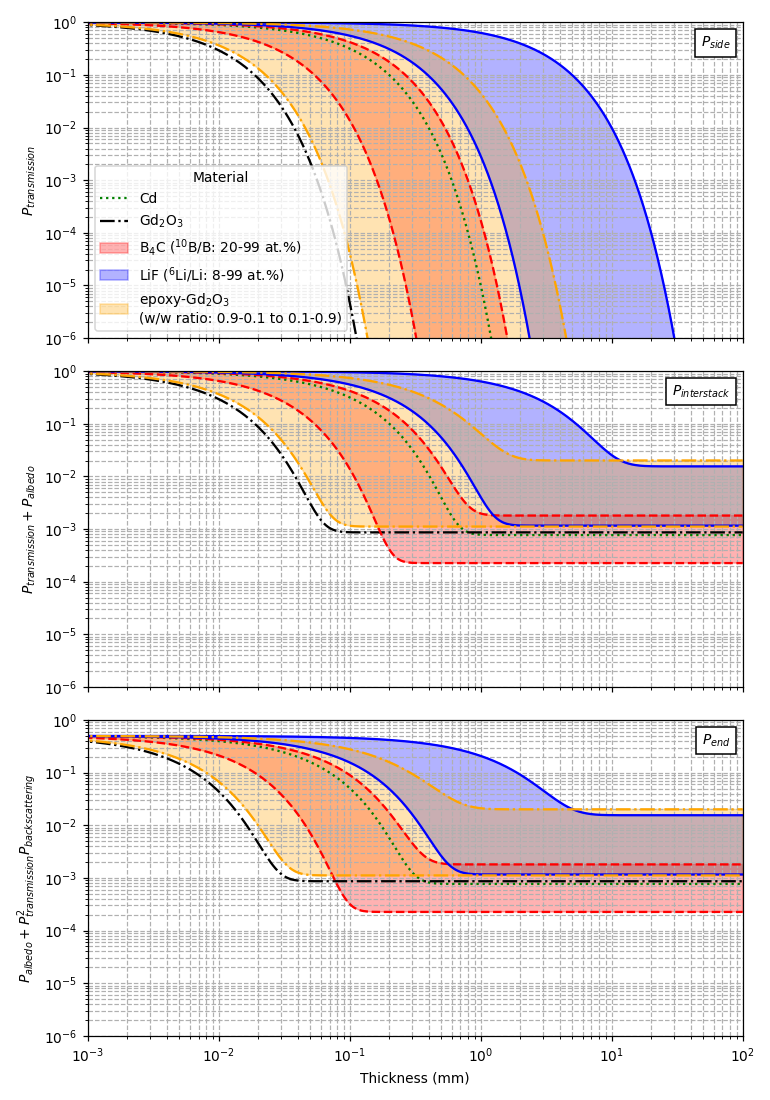

In [15]:
energy_in_eV = 0.02525
plot_probabilities(plot_groups, data_array, energy_in_eV)

## 3.3. Albedo saturation<a class="anchor" id="SAT"></a>

First, we declare a helper function to get the Albedo saturation level.

In [16]:
def get_albedo_saturation(thicknesses, p_albedo, p_transmission, saturation_fraction=0.95):
    """ Returns the thickness for which the albedo level saurates, the albedo saturation level
        as well as the ratio between transmission and albedo at that thickness.

    Args:
        thicknesses (np.array): Thicknesses in cm
        p_albedo (np.array): Albedo as a function of thickness (strictly increasing thicknesses)
        p_transmission (np.array): Transmission as a function of thickness (strictly increasing thicknesses)
        saturation_fraction (float): The fraction of maximum albedo level at which the albedo is considered
                                     saturated. The reason this is necessary is because the albedo saturation
                                     has log-like behaviour and the saturation converges very slowly towards
                                     its maximum.

    Returns:
        albedo_saturation_thickness (float): Thickness in cm for which the albedo level is saturated
        albedo_saturation_level (float): Albedo saturation level
        transmission_albedo_fraction (float): Ratio between transmission and albedo at the albedo
                                              saturation thickness.  

    """
    albedo_saturation_level = max(p_albedo) * saturation_fraction
    albedo_saturation_idx = np.where(p_albedo >= albedo_saturation_level)[0][0]
    albedo_saturation_thickness = thicknesses[1:][albedo_saturation_idx]
    transmission_albedo_fraction = p_transmission[1:][albedo_saturation_idx]/albedo_saturation_level
    return albedo_saturation_thickness, albedo_saturation_level, transmission_albedo_fraction

Then, we declare the code to calculate the albedo saturation information as a function of energy.

<IPython.core.display.Javascript object>


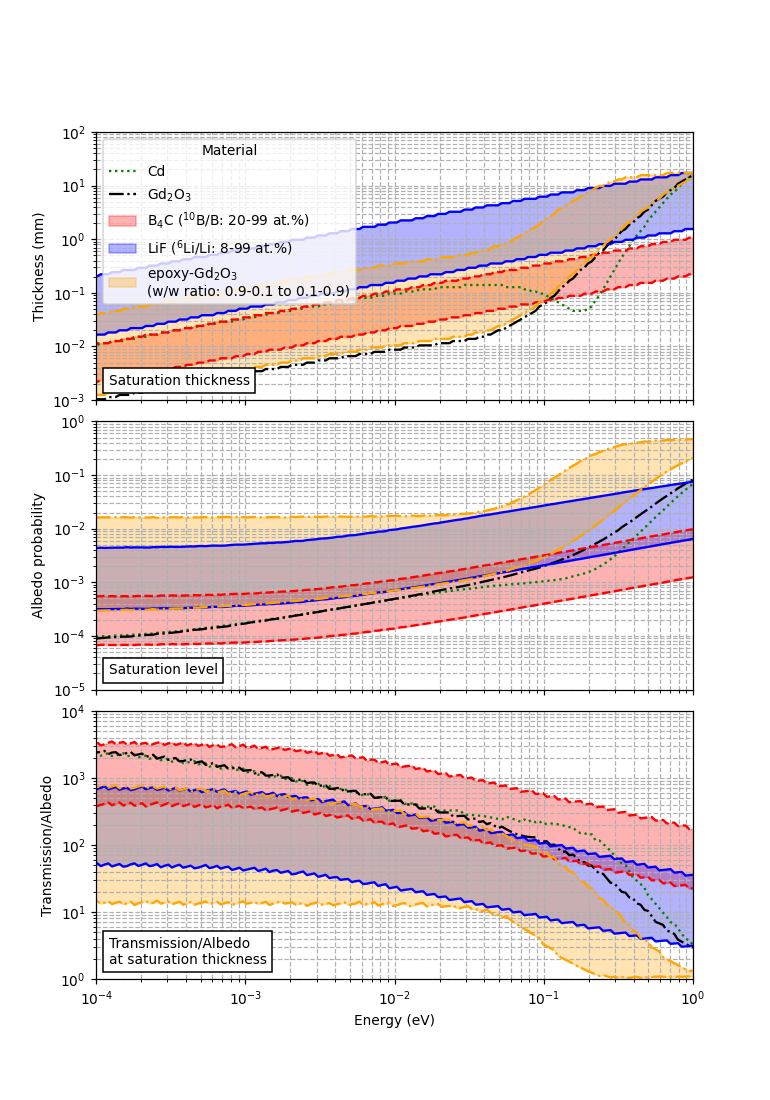

['Cd']
['Gd2O3']
['B4C_nat', 'B4C_enriched']
['LiF_nat', 'LiF_enriched']
['epoxy_Gd2O3_09_01', 'epoxy_Gd2O3_01_09']


In [27]:
# Declare parameters (THESE VALUES CAN BE MODIFIED FOR DIFFERENT ENERGY RANGES AND THICKNESSES)
number_elements = 200 # Recommended: 1000
thicknesses = np.logspace(-6, 2, number_elements) * 0.1  # in cm
energies = np.logspace(-5, 0, number_elements)

# Prepare plot    
set_thick_labels(9)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(7)
plt.subplots_adjust(hspace=.08)

# Plot cross sections from all materials
for plot_group in plot_groups.values():
    # Extract values
    materials = plot_group['materials']
    color = plot_group['color']
    label = plot_group['label']
    linestyle = plot_group['linestyle']
    # Plot values
    print(materials) # Print materials to show progress of calculation, might take a few minutes to complete
    if len(materials) == 1:
        # Extract values
        material = materials[0]
        data = data_array[material]['data']
        density = data_array[material]['density']
        # Calculate saturation
        dict_sat = {'thickness': np.empty(len(energies), dtype='float'),
                    'level': np.empty(len(energies), dtype='float'),
                    'fraction': np.empty(len(energies), dtype='float')
                    }
        for i, energy in enumerate(energies):
            # Calculate vales
            p_transmission, p_albedo = get_prob_vs_thickness(data, energy, density, thicknesses)
            sat_thick, sat_lev, sat_frac = get_albedo_saturation(thicknesses, p_albedo, p_transmission)
            # Store values in array
            dict_sat['thickness'][i] = sat_thick * 10 # Convert to mm
            dict_sat['level'][i] = sat_lev
            dict_sat['fraction'][i] = sat_frac
        # Plot
        ax1.plot(energies, dict_sat['thickness'], color=color, label=label, linestyle=linestyle)
        ax2.plot(energies, dict_sat['level'], color=color, label=label, linestyle=linestyle)
        ax3.plot(energies, dict_sat['fraction'], color=color, label=label, linestyle=linestyle)
    else:
        # Extract values
        material_1, material_2 = materials[0], materials[1]
        data_1, data_2 = data_array[material_1]['data'], data_array[material_2]['data']
        density_1, density_2 = data_array[material_1]['density'], data_array[material_2]['density']
        # Calculate saturation
        dict_sat = {'thickness': np.empty([2, len(energies)], dtype='float'),
                    'level': np.empty([2, len(energies)], dtype='float'),
                    'fraction': np.empty([2, len(energies)], dtype='float')
                    }
        for i, energy in enumerate(energies):
            # Calculate vales
            p_transmission_1, p_albedo_1 = get_prob_vs_thickness(data_1, energy, density_1, thicknesses)
            p_transmission_2, p_albedo_2 = get_prob_vs_thickness(data_2, energy, density_2, thicknesses)
            sat_thick_1, sat_lev_1, sat_frac_1 = get_albedo_saturation(thicknesses, p_albedo_1, p_transmission_1)
            sat_thick_2, sat_lev_2, sat_frac_2 = get_albedo_saturation(thicknesses, p_albedo_2, p_transmission_2)
            # Store values in array
            dict_sat['thickness'][0][i] = sat_thick_1 * 10 # Convert to mm
            dict_sat['level'][0][i] = sat_lev_1
            dict_sat['fraction'][0][i] = sat_frac_1
            dict_sat['thickness'][1][i] = sat_thick_2 * 10 # Convert to mm
            dict_sat['level'][1][i] = sat_lev_2
            dict_sat['fraction'][1][i] = sat_frac_2
        # Plot
        ax1.plot(energies, dict_sat['thickness'][0], color=color, label=None, linestyle=linestyle)
        ax1.plot(energies, dict_sat['thickness'][1], color=color, label=None, linestyle=linestyle)
        ax1.fill_between(energies, dict_sat['thickness'][1], dict_sat['thickness'][0],
                         color=color, label=label, alpha=0.3)
        ax2.plot(energies, dict_sat['level'][0], color=color, label=None, linestyle=linestyle)
        ax2.plot(energies, dict_sat['level'][1], color=color, label=None, linestyle=linestyle)
        ax2.fill_between(energies, dict_sat['level'][1], dict_sat['level'][0],
                         color=color, label=label, alpha=0.3)
        ax3.plot(energies, dict_sat['fraction'][0], color=color, label=None, linestyle=linestyle)
        ax3.plot(energies, dict_sat['fraction'][1], color=color, label=None, linestyle=linestyle)
        ax3.fill_between(energies, dict_sat['fraction'][1], dict_sat['fraction'][0],
                         color=color, label=label, alpha=0.3)

# Stylize plot
ax1.set_ylabel('Thickness (mm)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, which='major', linestyle='--', zorder=0)
ax1.grid(True, which='minor', linestyle='--', zorder=0)
ax1.set_xlim(1e-4, 1)
ax1.set_ylim(1e-3, 1e2)
ax1.legend(title='Material', loc=2)
ax1.add_artist(AnchoredText("Saturation thickness", loc=3))

ax2.set_ylabel('Albedo probability')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e-4, 1)
ax2.set_ylim(1e-5, 1)
ax2.grid(True, which='major', linestyle='--', zorder=0)
ax2.grid(True, which='minor', linestyle='--', zorder=0)
ax2.add_artist(AnchoredText("Saturation level", loc=3))

ax3.set_ylabel('Transmission/Albedo')
ax3.set_xlabel('Energy (eV)')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(1e-4, 1)
ax3.set_ylim(1, 1e4)
ax3.grid(True, which='major', linestyle='--', zorder=0)
ax3.grid(True, which='minor', linestyle='--', zorder=0)
ax3.add_artist(AnchoredText("Transmission/Albedo\nat saturation thickness", loc=3))

# Save plot
fig.savefig('output/albedo_saturation.pdf' % energy, bbox_inches='tight')

## 3.4. Transmission iso-lines<a class="anchor" id="ISO_LINES"></a>

Here we declare the code to investigate constant transmission probabilities as a function of energy and thickness.

<IPython.core.display.Javascript object>


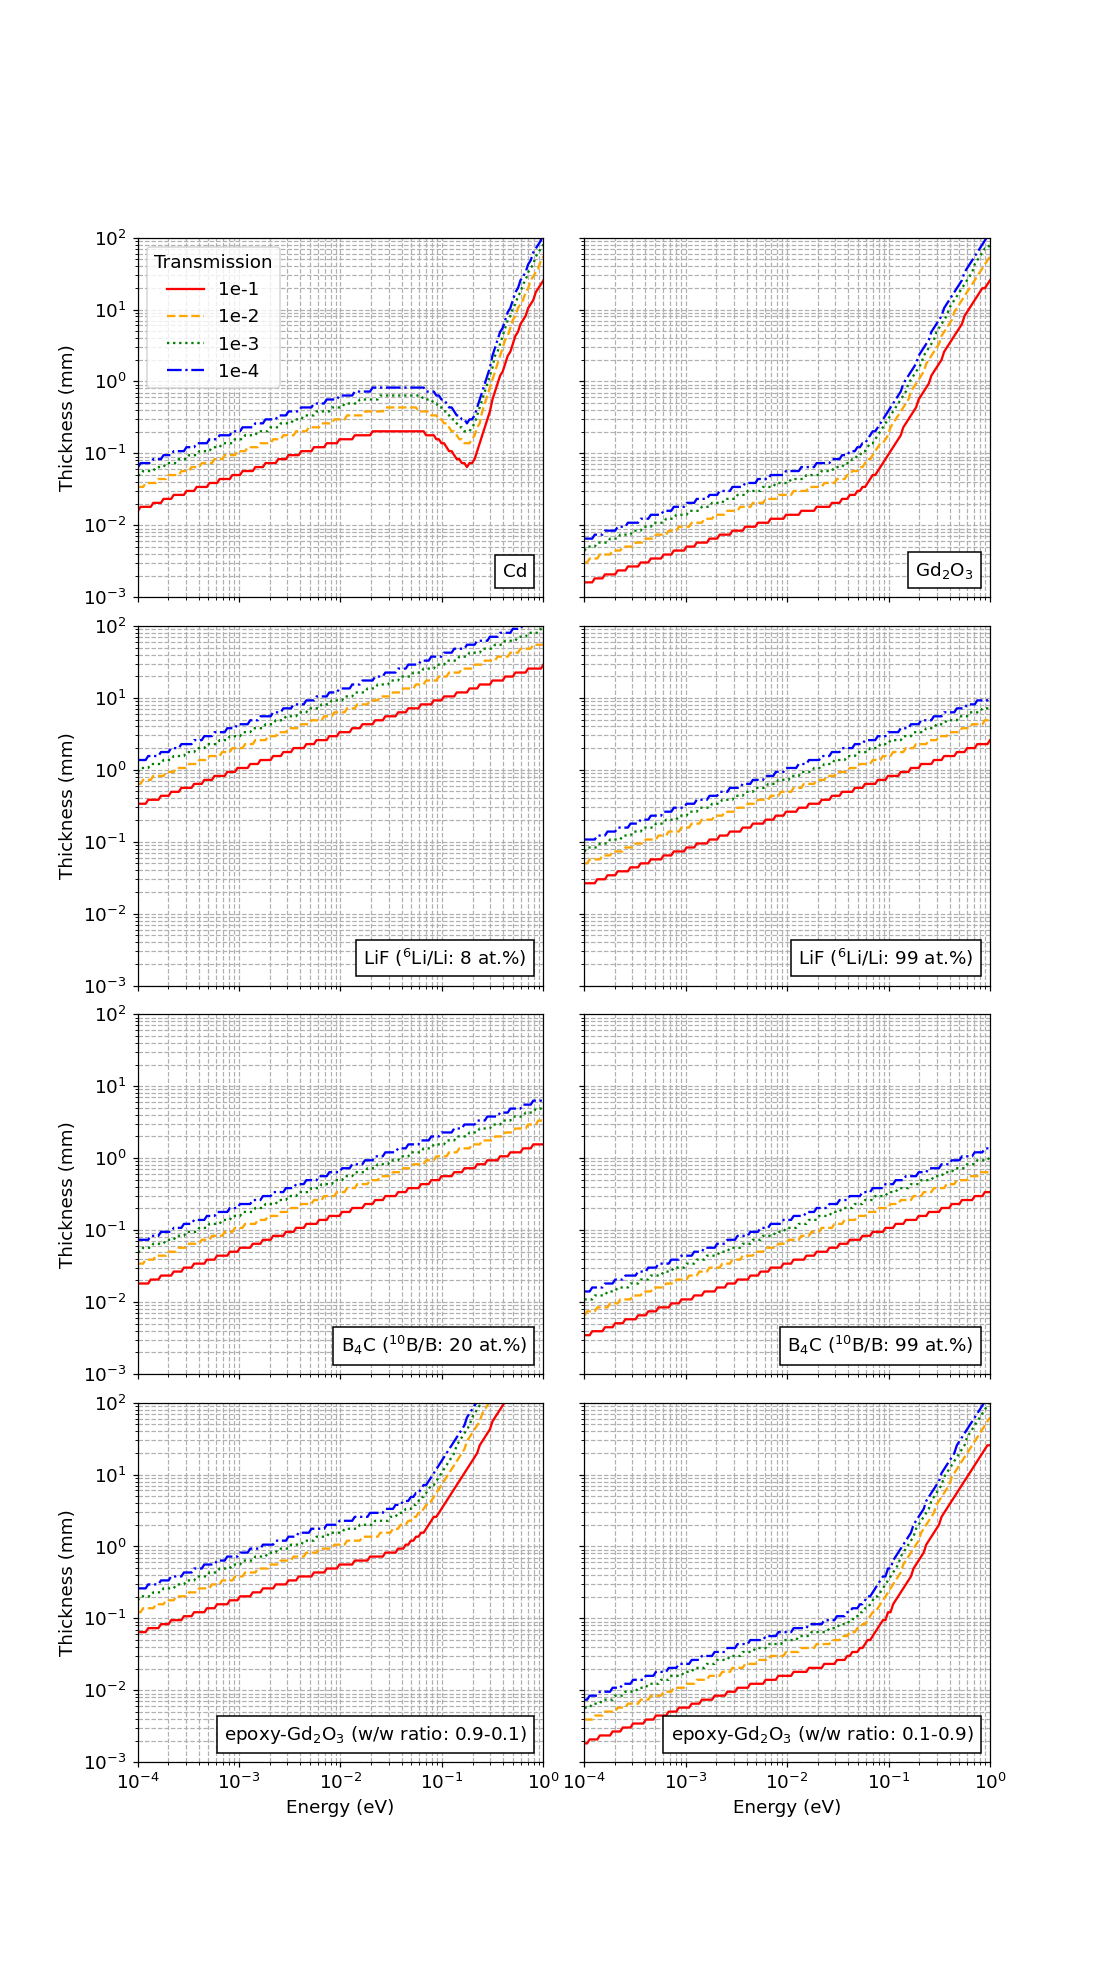

Cd
Gd$_2$O$_3$
B$_4$C ($^{10}$B/B: 20 at.%)
B$_4$C ($^{10}$B/B: 99 at.%)
LiF ($^{6}$Li/Li: 8 at.%)
LiF ($^{6}$Li/Li: 99 at.%)
epoxy-Gd$_2$O$_3$ (w/w ratio: 0.9-0.1)
epoxy-Gd$_2$O$_3$ (w/w ratio: 0.1-0.9)


In [26]:
# Declare parameters
number_elements = 200 # Recommended: 1000
transmission_levels = [0.1, 0.01, 0.001, 0.0001]
thicknesses = np.logspace(-6, 5, number_elements) * 0.1  # The unit must be in cm
energies = np.logspace(-5, 0, number_elements)

# Prepare plot
set_thick_labels(12)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, sharex='col', sharey='row')
fig.set_figheight(18)
fig.set_figwidth(10)
plt.subplots_adjust(hspace=.08, wspace=.1)

# Define plot parameters
colors = ['red', 'orange', 'green', 'blue']
linestyles = ['-', '--', 'dotted', '-.']
levels = ['1e-1', '1e-2', '1e-3', '1e-4']
axes = [ax1, ax2, ax5, ax6, ax3, ax4, ax7, ax8]

# Plot
for i, (material, ax) in enumerate(zip(data_array.values(), axes)):
    # Extract values
    data = material['data']
    density = material['density']
    label = material['label']
    print(label) # Print material label to check progress (might take ~20 minutes to complete)
    # Perform transmission calculation for each transmission level
    for j, transmission_level in enumerate(transmission_levels):
        required_thicknesses = np.empty([len(energies)], dtype='float')
        for k, energy in enumerate(energies):
            p_transmission, __ = get_prob_vs_thickness(data, energy, density, thicknesses)
            thickness = thicknesses[get_idx_closest(p_transmission, transmission_level)]
            required_thicknesses[k] = thickness*10 # Convert unit to mm
        ax.plot(energies, required_thicknesses, color=colors[j], linestyle=linestyles[j], label=levels[j])
    # Stylize plot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4, 1)
    ax.set_ylim(1e-3, 1e2)
    ax.add_artist(AnchoredText(label, loc=4))
    ax.grid(True, which='major', linestyle='--', zorder=0)
    ax.grid(True, which='minor', linestyle='--', zorder=0)
    if i % 2 == 0:
        ax.set_ylabel('Thickness (mm)')
    if (i == 6) or (i == 7):
        ax.set_xlabel('Energy (eV)')
    if i == 0:
        ax.legend(title='Transmission', loc=2)

# Save plot
fig.savefig('output/transmission_vs_thickness_and_energy.pdf', bbox_inches='tight')

# 4. Shielding finder tool<a class="anchor" id="TOOL"></a>

First, we define functions to calculate an appropriate shielding configuration.

In [19]:
def calculate_constraints(parameter_dict):
    """ Calculates the constraints based on the details in 'parameter_dict', which specifies the conditions
        of a specific shielding problem.

    Args:
        parameter_dict (dict): Dictionary containing the details of a specific shielding problem.
                               The format, with example values of the parameters, is:
                              
                                     parameter_dict = {'space_available_side_in_mm': 0.5,
                                                       'space_available_end_in_mm': 4,
                                                       'space_available_interstack_in_mm': 1,
                                                       'maximum_neutron_energy_in_eV': 0.168,
                                                       'desired_SBR': 1e4,
                                                       'phi_incident': 1,
                                                       'phi_interstack': 0.01,
                                                       'phi_side': 0.1,
                                                       'phi_end': 0.5}
                                


    Returns:
        constraints (dict): Dictionary containing the constraints on how thick the different shielding can
                            be and what the desired background probabilities should be kept below.
                            The constraints dict is expressed in the following format:

                                constraints = {'constraints_side': [space_available_side,
                                                                    p_side_maximum],
                                               'constraints_end': [space_available_end,
                                                                   p_end_maximum],
                                               'constraints_interstack': [space_available_interstack,
                                                                          p_interstack_maximum]
                                               }


    """
    # Define constraints
    space_available_side = parameter_dict['space_available_side_in_mm']
    space_available_end = parameter_dict['space_available_end_in_mm']
    space_available_interstack = parameter_dict['space_available_interstack_in_mm']
    desired_SBR = parameter_dict['desired_SBR']

    # Approximate flux hitting difference parts of detector
    phi_incident = parameter_dict['phi_incident']
    phi_interstack = parameter_dict['phi_interstack']
    phi_side = parameter_dict['phi_side']
    phi_end = parameter_dict['phi_end']

    # Using this information, we can then calculate the required minimum
    # leakage probability out of each shielding
    p_side_maximum = (desired_SBR * (phi_side/phi_incident)) ** (-1)
    p_end_maximum = (desired_SBR * (phi_end/phi_incident)) ** (-1)
    p_interstack_maximum = (desired_SBR * (phi_interstack/phi_incident)) ** (-1)

    # Next, we use these contraints to find the range of materials we can use
    constraints_side = [space_available_side, p_side_maximum]
    constraints_end = [space_available_end, p_end_maximum]
    constraints_interstack = [space_available_interstack, p_interstack_maximum]
    constraints = {'constraints_side': constraints_side,
                   'constraints_end': constraints_end,
                   'constraints_interstack': constraints_interstack
                   }
    return constraints
    

def shielding_finder(plot_groups, data_array, parameter_dict):
    """ Function to plot probability of getting background neutrons from the different shielding components
        as a function of thickness, together with a green area showing the desired
        properties of the shielding materials.

    Args:
        plot_groups (dict): Dictionary conating all information for how the plotting should be done.
                            This includes which materials are to be paired (i.e. natural and enriched B4C),
                            which linestyle and color the plots should have, as well as labels.
        data_array (dict): Dictionary containg all relevant material data
        parameter_dict (dict): Dictionary containing the details of a specific shielding problem.
                               The format, with example values of the parameters, is:
                              
                                     parameter_dict = {'space_available_side_in_mm': 0.5,
                                                       'space_available_end_in_mm': 4,
                                                       'space_available_interstack_in_mm': 1,
                                                       'maximum_neutron_energy_in_eV': 0.168,
                                                       'desired_SBR': 1e4,
                                                       'phi_incident': 1,
                                                       'phi_interstack': 0.01,
                                                       'phi_side': 0.1,
                                                       'phi_end': 0.5}

    Yields:
        Plot depicting the probability of getting background neutrons from the different shielding components
        as a function of thickness, together with a green area showing the desired
        properties of the shielding materials. The plot is also saved in the 'output'-folder.

    """
    
    # Define constraints
    maximum_neutron_energy = parameter_dict['maximum_neutron_energy_in_eV']
    constraints = calculate_constraints(parameter_dict)

    # Finally, we plot transmission and albedo with these constraints. Note that the GREEN REGION
    # contains the materials which can fulfill the performance requirement with the available space.
    plot_probabilities(plot_groups, data_array, maximum_neutron_energy, constraints=constraints)

Then, we add two example configurations: one for T-REX and one for CSPEC Multi-Grid detectors. The green area indicates the thickness and performance needed to fulfill the performance requirement within the space available for shielding.

<IPython.core.display.Javascript object>


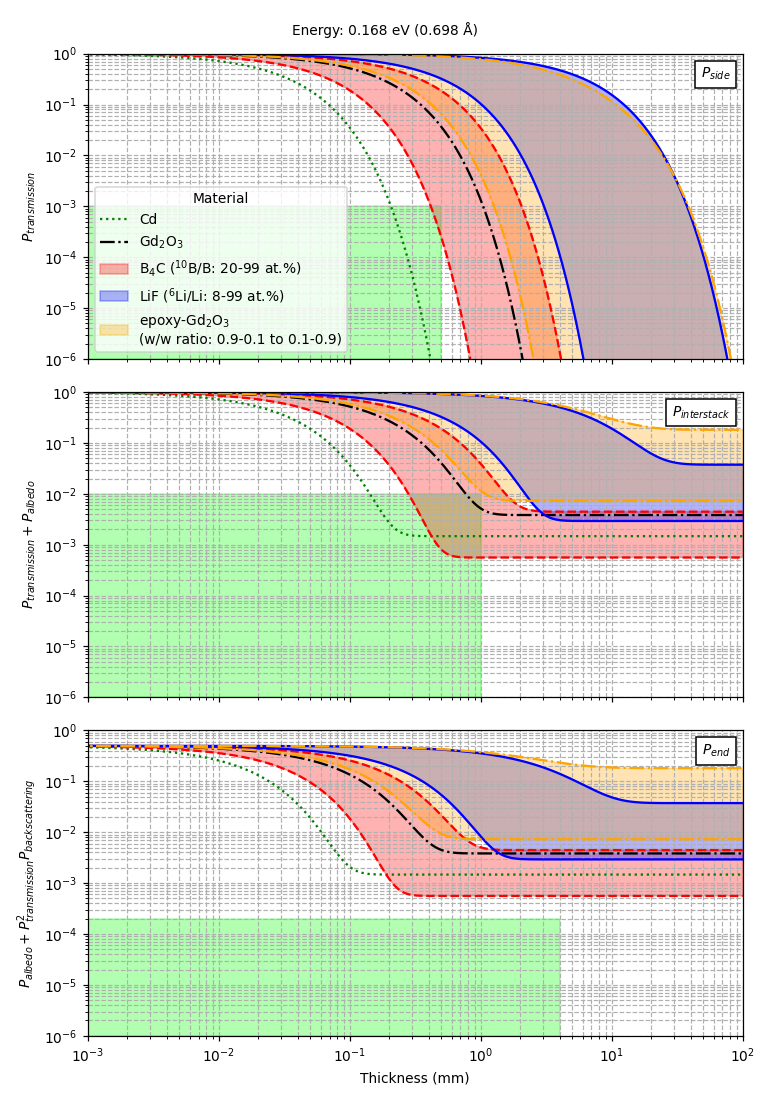

<IPython.core.display.Javascript object>


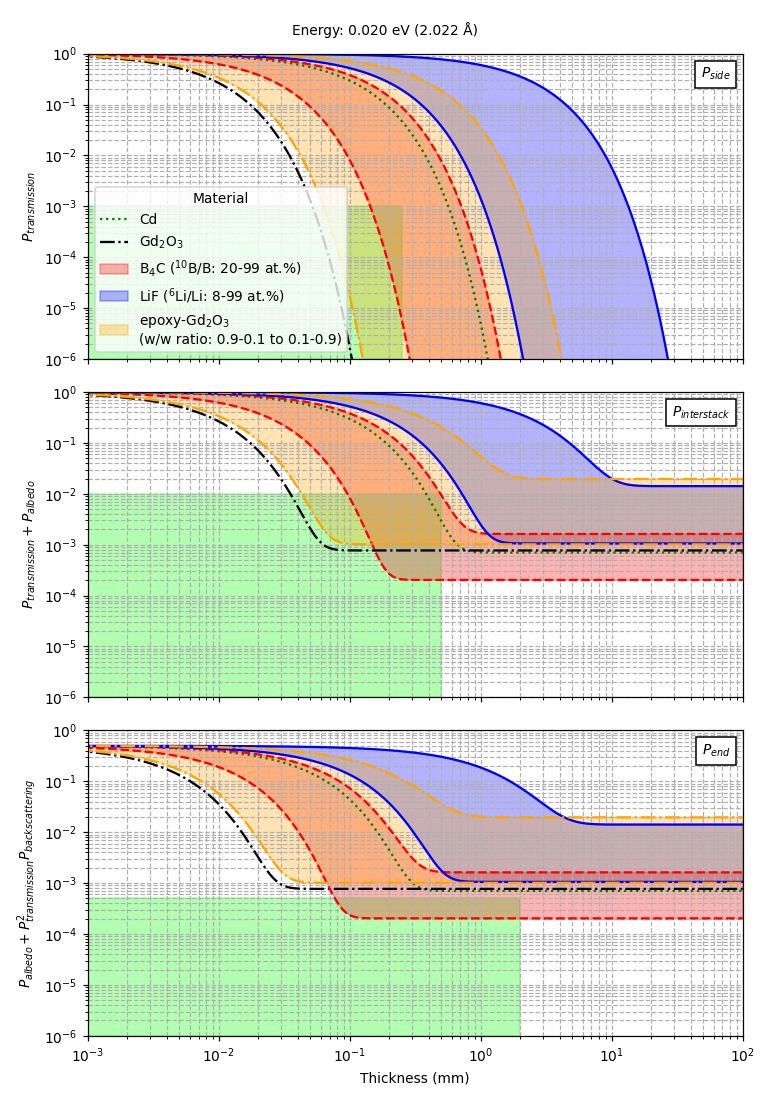

In [20]:
parameter_dict_trex = {'space_available_side_in_mm': 0.5,
                       'space_available_end_in_mm': 4,
                       'space_available_interstack_in_mm': 1,
                       'maximum_neutron_energy_in_eV': 0.168,
                       'desired_SBR': 1e4,
                       'phi_incident': 1,
                       'phi_interstack': 0.01,
                       'phi_side': 0.1,
                       'phi_end': 0.5}

parameter_dict_cspec = {'space_available_side_in_mm': 0.25,
                        'space_available_end_in_mm': 2,
                        'space_available_interstack_in_mm': 0.5,
                        'maximum_neutron_energy_in_eV': 0.020,
                        'desired_SBR': 1e4,
                        'phi_incident': 1,
                        'phi_interstack': 0.01,
                        'phi_side': 0.1,
                        'phi_end': 0.2}

shielding_finder(plot_groups, data_array, parameter_dict_trex)
shielding_finder(plot_groups, data_array, parameter_dict_cspec)

# 5. Custom material investigation<a class="anchor" id="CUSTOM"></a>

Here it is possible to look at other materials than those investigated in the paper.

<IPython.core.display.Javascript object>


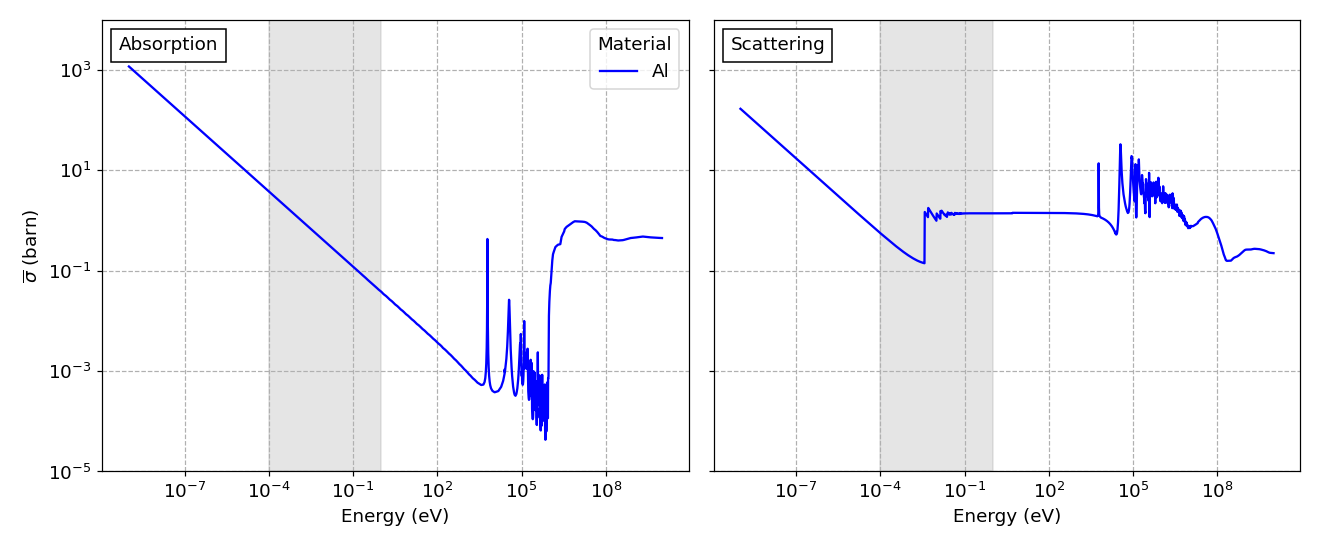

<IPython.core.display.Javascript object>


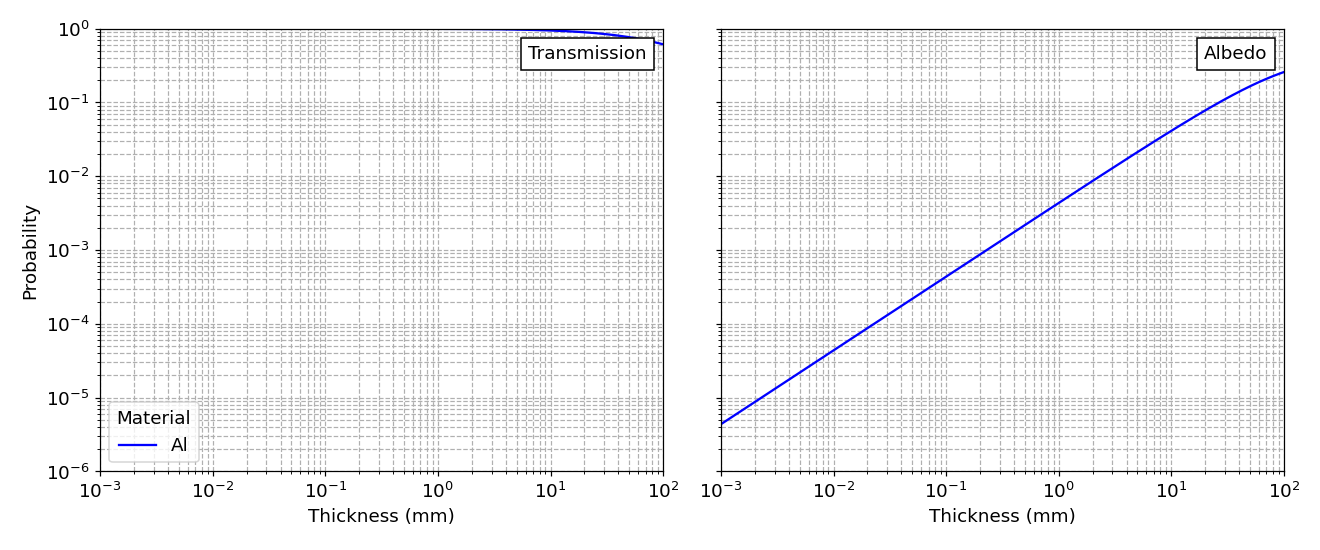

<IPython.core.display.Javascript object>


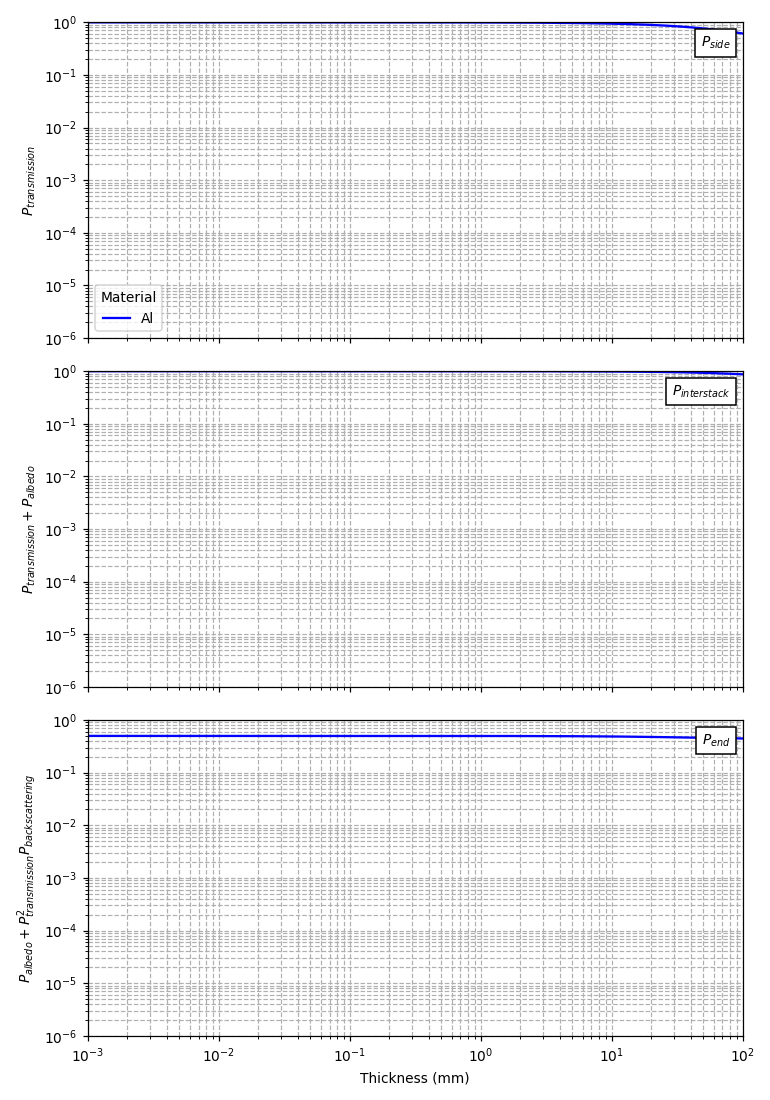

<IPython.core.display.Javascript object>


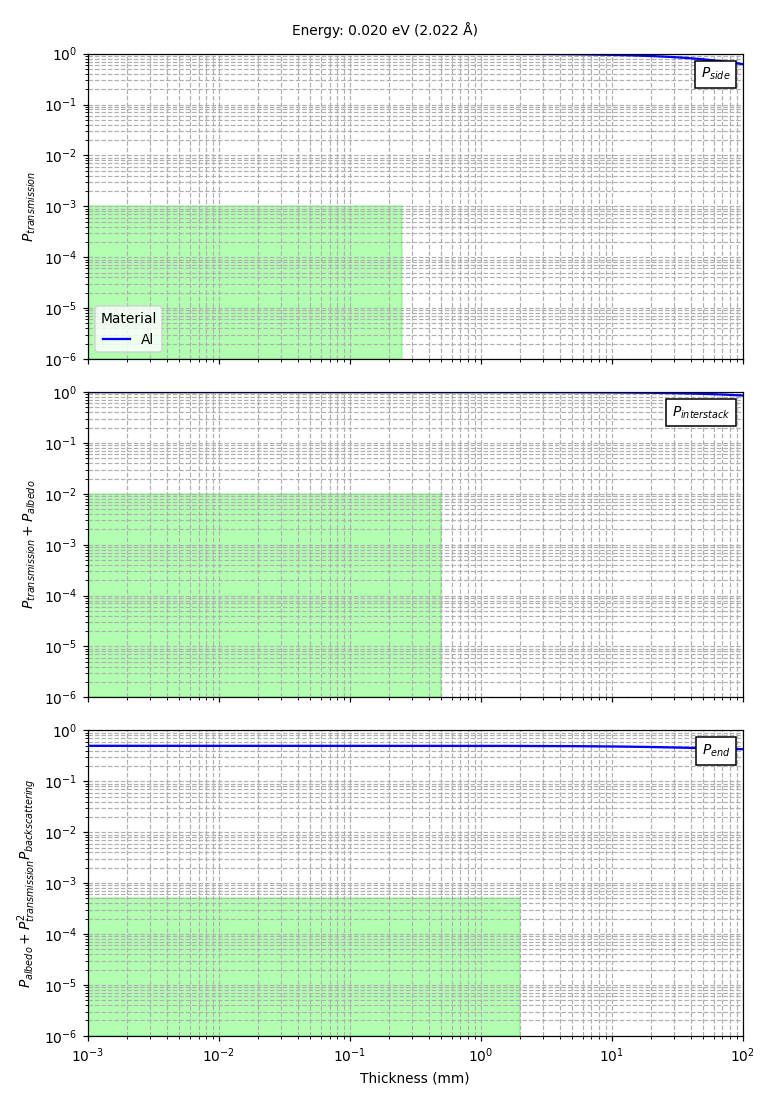

In [28]:
# Declare dictionary to store custom data
custom_data_array = {'Al': {'file_name': 'Al.txt',
                            'label': 'Al',
                            'data': None,
                            'density': None},
                     
                     #################################
                     # ENTER YOUR OWN MATERIALS HERE #
                     #################################
                     
                     }

# Define custom plot groups (a plot group can have 1 or 2 materials)
custom_plot_groups = {'Al': {'materials': ['Al'],
                             'color': 'blue',
                             'label': 'Al',
                             'linestyle': '-'},

                       #################################
                       # ENTER YOUR OWN MATERIALS HERE #
                       #################################
                      
                       }

# Import custom data
for material in custom_data_array.keys():
    # Get data and density
    file_name = custom_data_array[material]['file_name']
    path = 'data/%s' % file_name
    data, density = parse_data(path)
    # Store in array
    custom_data_array[material]['data'] = data
    custom_data_array[material]['density'] = density

# Define parameters
energy_in_eV = 0.02525
    
# Plot data
plot_cross_sections(custom_data_array, custom_plot_groups, ymin=1e-5, ymax=1e4)
plot_transmission_and_albedo(custom_plot_groups, custom_data_array, energy_in_eV)
plot_probabilities(custom_plot_groups, custom_data_array, energy_in_eV)

# Use shielding finder tool on custom data
parameter_dict_cspec = {'space_available_side_in_mm': 0.25,
                        'space_available_end_in_mm': 2,
                        'space_available_interstack_in_mm': 0.5,
                        'maximum_neutron_energy_in_eV': 0.020,
                        'desired_SBR': 1e4,
                        'phi_incident': 1,
                        'phi_interstack': 0.01,
                        'phi_side': 0.1,
                        'phi_end': 0.2}
shielding_finder(custom_plot_groups, custom_data_array, parameter_dict_cspec)

# 6. Extra<a class="anchor" id="EXTRA"></a>

Here it is possible to define additional analysis functions to look at other properties than those investigated in the paper.

In [22]:
# Here define a series of extra helper functions to aid with analysis
def plot_probabilities_for_many_energies(material, energies, constraints=None):
    """ Calculates the constraints based on the details in 'parameter_dict', which specifies the conditions
        of a specific shielding problem.

    Args:
        material (dict): Dictionary containg all the relevant material properties, which should contain
                         data with absorption and scattering probabilities, density (#atoms per cubic cm)
                         and a label for which it should be plotted.
                         
        energies (np.array): Array with energies that should be plotted
                         
                              
        constraints (dict): Dictionary containing the constraints on how thick the different shielding can
                            be and what the desired background probabilities should be kept below.
                            The constraints dict is expressed in the following format:

                                constraints = {'constraints_side': [space_available_side,
                                                                    p_side_maximum],
                                               'constraints_end': [space_available_end,
                                                                   p_end_maximum],
                                               'constraints_interstack': [space_available_interstack,
                                                                          p_interstack_maximum]
                                               }
        
    Yields:
        Plot depicting the shielding material performance for several energies.
        The plot is also saved in the 'output'-folder.


    """
    # Declare parameters
    xmin, xmax = 1e-3, 1e2
    ymin, ymax = 1e-6, 1
    thicknesses = np.logspace(-7, 2, 1000) * 0.1  # in cm
    
    # Extract values
    data = material['data']
    density = material['density']
    label = material['label']

    # Prepare plot    
    set_thick_labels(9)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, sharey=True)
    plt.subplots_adjust(hspace=.08)
    fig.suptitle('%s, %.3f - %.3f meV' % (label, energies[0]*1000, energies[-1]*1000))
    colors = cm.rainbow(np.linspace(0, 1, len(energies)))
    
    # Iterate through all energies
    for color, energy in zip(colors, energies):
        # Calculate probabilities
        p_transmission, p_albedo = get_prob_vs_thickness(data, energy, density, thicknesses)
        p_side, p_interstack, p_end = get_prob_side_interstack_and_end(p_transmission, p_albedo)
        # Plot
        plot_label = '%.3f meV (%.3f Å)' % (energy*1000, meV_to_A(energy*1000))
        ax1.plot(thicknesses[1:]*10, p_side, color=color, label=plot_label)
        ax2.plot(thicknesses[1:]*10, p_interstack, color=color, label=plot_label)
        ax3.plot(thicknesses[1:]*10, p_end, color=color, label=plot_label)

        
    # Stylize plot
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(True, which='major', linestyle='--', zorder=0)
    ax1.grid(True, which='minor', linestyle='--', zorder=0)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    #ax1.legend(title='Material', loc=3)
    ax1.set_ylabel('$P_{transmission}$')
    ax1.add_artist(AnchoredText('$P_{side}$', loc=1))
    if constraints is not None:
        space_available_side, p_side_maximum = constraints['constraints_side']
        ax1.fill_betweenx([ymin, p_side_maximum], xmin, space_available_side, color='lime',
                          alpha=0.3, label=None, zorder=0)
    
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin, ymax)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, which='major', linestyle='--', zorder=0)
    ax2.grid(True, which='minor', linestyle='--', zorder=0)
    ax2.set_ylabel('$P_{transmission} + P_{albedo}$')
    ax2.add_artist(AnchoredText('$P_{interstack}$', loc=1))
    if constraints is not None:
        space_available_interstack, p_interstack_maximum = constraints['constraints_interstack']
        ax2.fill_betweenx([ymin, p_interstack_maximum], xmin, space_available_interstack, color='lime',
                          alpha=0.3, label=None, zorder=0)
    
    ax3.set_xlim(xmin, xmax)
    ax3.set_ylim(ymin, ymax)
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.grid(True, which='major', linestyle='--', zorder=0)
    ax3.grid(True, which='minor', linestyle='--', zorder=0)
    ax3.set_xlabel('Thickness (mm)')
    ax3.set_ylabel('$P_{albedo} + P_{transmission}^2P_{backscattering}$')
    ax3.add_artist(AnchoredText('$P_{end}$', loc=1))
    if constraints is not None:
        space_available_end, p_end_maximum = constraints['constraints_end']
        ax3.fill_betweenx([ymin, p_end_maximum], xmin, space_available_end, color='lime',
                          alpha=0.3, label=None, zorder=0)
    
    fig.set_figheight(10)
    fig.set_figwidth(7)
    plt.tight_layout()

    # Save plot
    fig.savefig('output/probabilities_for_many_energies.pdf', bbox_inches='tight')

Here we can run our extra analysis.

<IPython.core.display.Javascript object>


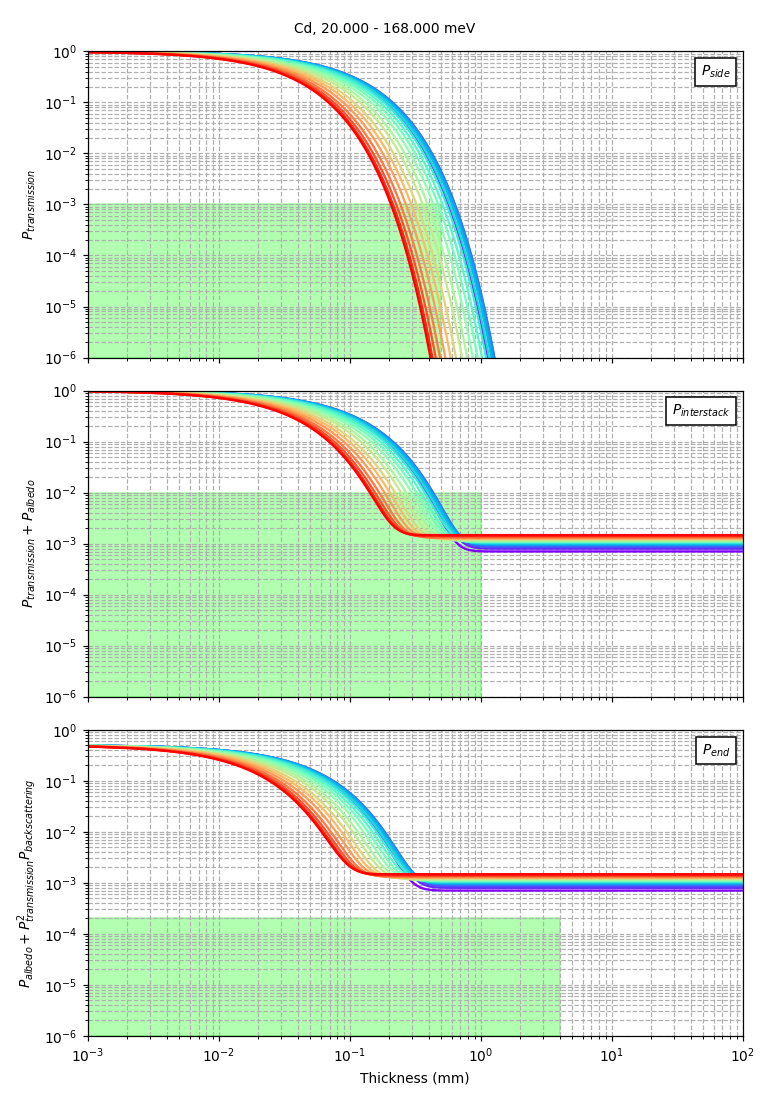

In [24]:
parameter_dict_trex = {'space_available_side_in_mm': 0.5,
                       'space_available_end_in_mm': 4,
                       'space_available_interstack_in_mm': 1,
                       'maximum_neutron_energy_in_eV': 0.168,
                       'desired_SBR': 1e4,
                       'phi_incident': 1,
                       'phi_interstack': 0.01,
                       'phi_side': 0.1,
                       'phi_end': 0.5}

energies = np.linspace(0.02, 0.168, 20)
constraints = calculate_constraints(parameter_dict_trex)
plot_probabilities_for_many_energies(data_array['Cd'], energies, constraints=constraints)